# Basic experiment section

This section focuses on performing basic experiment with BERT. Here we use BERT on SCOP2 dataset to generate features and give it to some trivial NN.  

Experiment performed here is supposed to proof that there is at least some sense in using BERT (there shall be).

## Data preparation

Here we just use data preparation module to get sample and target.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn
! pip3 install torchinfo
from torchinfo import summary
import torchvision
import torch 
from IPython.display import clear_output
from torch.utils.data import Dataset, random_split
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from collections import defaultdict
import time


In [ ]:
import os
import shutil

import glob
import requests

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir /content/drive/MyDrive/m1p

In [ ]:
!mkdir /content/drive/MyDrive/m1p/albert_data

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.0MB 17.2MB/s 
     |████████████████████████████████| 890kB 54.0MB/s 
     |████████████████████████████████| 3.2MB 54.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=b4d1a33e0a4be5ef2734b7f4ce3937f0874310eb306d9c54c4c6d508d628e87a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 23.3MB/s 


In [ ]:
from transformers import AlbertTokenizer, XLNetTokenizer, AutoModel, pipeline
import re
import os
import requests
from tqdm.auto import tqdm

In [ ]:
tokenizer = AlbertTokenizer.from_pretrained("Rostlab/prot_albert", do_lower_case=False )
#tokenizer = XLNetTokenizer.from_pretrained("Rostlab/prot_xlnet", do_lower_case=False)



In [ ]:
model = AutoModel.from_pretrained("Rostlab/prot_albert")
#model = AutoModel.from_pretrained("Rostlab/prot_xlnet")

In [ ]:
fe = pipeline('feature-extraction', model=model, tokenizer=tokenizer,device=0)

In [ ]:
def scop_seq_to_bert_seq(scop_seq):
    """
    Converts sequences from scop format to prot bert format
    """
    def expand(sequence):
        """
        Expands one sequnce
        """
        return " ".join(sequence.rstrip())
    
    return scop_seq.apply(expand)

In [ ]:
# data = prepare_scop_data()
seq_data = pd.read_csv("/content/drive/MyDrive/m1p/seq_to_fold.csv")
seq_data = seq_data[["FOLD", "sequence"]]
seq_data.head()

,FOLD,sequence
0,1400,DMKRQQRFFRIPFIRPADQYKDPQNKKKGWWYAHFDGPWIARQMEL...
1,1400,RQREIEMNRQQRFFRIPFIRPADQYKDPQSKKKGWWYAHFDGPWIA...
2,11,MKIKVALLDKDKEYLDRLTGVFNTKYADKLEVYSFTDEKNAIESVK...
3,11,QTPHILIVEDELVTRNTLKSIFEAEGYDVFEATDGAEMHQILSEYD...
4,11,SFERVFGKRVIILGGGALVSQVAIGAISEADRHNLRGERISVDTMP...


In [ ]:
sequences = seq_data['sequence']
sequences = scop_seq_to_bert_seq(sequences).to_numpy()
target = seq_data['FOLD'].to_numpy()

In [ ]:
sequences[:5]

array(['D M K R Q Q R F F R I P F I R P A D Q Y K D P Q N K K K G W W Y A H F D G P W I A R Q M E L H P D K P P I L L V A G K D D M E M C E L N L E E T G L T R K R G A E I L P R Q F E E I W E R C G G I Q Y L Q S A I E S R Q A R P T Y A T A M L Q N L L',
       'R Q R E I E M N R Q Q R F F R I P F I R P A D Q Y K D P Q S K K K G W W Y A H F D G P W I A R Q M E L H P D K P P I L L V A G K D D M E M C E L N L E E T G L T R K R G A E I L P R Q F E E I W E R C G G I Q Y L Q N A I E S R Q A R P T Y A T A M L Q S',
       'M K I K V A L L D K D K E Y L D R L T G V F N T K Y A D K L E V Y S F T D E K N A I E S V K E Y R I D V L I A E E D F N I D K S E F K R N C G L A Y F T G T P G I E L I K D E I A I C K Y Q R V D V I F K Q I L G V Y S D M A A N V A T',
       'Q T P H I L I V E D E L V T R N T L K S I F E A E G Y D V F E A T D G A E M H Q I L S E Y D I N L V I M D I N L P G K N G L L L A R E L R E Q A N V A L M F L T G R D N E V D K I L G L E I G A D D Y I T K P F N P R E L T I R A R N L L S 

In [ ]:
target[:5]

array([1400, 1400,   11,   11,   11])

In [ ]:
torch.tensor(fe(sequences[129])).shape

torch.Size([1, 123, 4096])

In [ ]:
for i in tqdm(range(len(sequences))):
  torch.save(torch.tensor(fe(sequences[i])), "/content/drive/MyDrive/m1p/albert_data/" + str(i) + ".torch")


In [ ]:
embedding = fe(list(sequences[10000:10005]))
e_arr = np.array(embedding)
e_arr.shape

(5, 98, 4096)

In [ ]:
sequences_Example = ["A E T C Z A O","S K T Z P"]
embedding = fe(sequences_Example)
arr = np.array(embedding)
arr.shape

(2, 9, 4096)

In [ ]:
embedding = fe(list(sequences[:5]))
arr = np.array(embedding)
arr.shape


(5, 136, 4096)

**Using CNN**:

In [ ]:
class K_max_pooling_1d(nn.Module):
    def __init__(self, k):
        super(K_max_pooling_1d, self).__init__()
        self.k = k

    def forward(self, x):
        if x.shape[2] < self.k:
          return F.pad(input=x, pad=(0, self.k - x.shape[2], 0, 0), 
                         mode='constant', value=0)
        top = torch.topk(x, k = self.k)
        return top.values

In [ ]:
 def plot_learning_curves(history):
    '''
    Функция для вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    # sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    label,
    num_epochs=50
):

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            
            #X_batch = torch.transpose(torch.tensor(fe(train_X[i])), 1, 2).to(device)
            #y_batch = torch.tensor(train_Y[i]).unsqueeze(0).to(device)
                        
            X_batch = torch.transpose(X_batch.squeeze(0), 1, 2).to(device)
            y_batch = y_batch.to(device)

            # Логиты на выходе модели
            logits = model(X_batch)

            # Подсчитываем лосс
            loss = criterion(logits, y_batch.long().to(device))

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()
            
            # Сохраяняем лоссы и точность на трейне
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            X_batch = torch.transpose(X_batch.squeeze(0), 1, 2).to(device)
            y_batch = y_batch.to(device)
            
            #X_batch = torch.transpose(torch.tensor(fe(val_X[i])), 1, 2).to(device)
            #y_batch = torch.tensor(val_Y[i]).unsqueeze(0).to(device)
            
            # Логиты, полученные моделью
            logits = model(X_batch)
            # Лосс на валидации
            loss = criterion(logits, y_batch.long().to(device))

            # Сохраяняем лоссы и точность на валидации
            val_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        if epoch % 5 == 1:
            torch.save(model.state_dict(), 
                   "/content/drive/MyDrive/m1p/model_state_" + label + "_" + str(epoch))
    return model, history

In [ ]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv1d(in_channels=4096, out_channels=10, 
                                    kernel_size=7, stride=1, padding=3))
model.add_module('relu1', nn.ReLU())
for i in range(2, 11):
  
  model.add_module('conv' + str(i), nn.Conv1d(in_channels=10, out_channels=10, 
                                      kernel_size=7, stride=1, padding=3))
  model.add_module('relu2' + str(i), nn.ReLU())
model.add_module('K_max_pooling', K_max_pooling_1d(30))
model.add_module('flatteing', nn.Flatten())
model.add_module('FC-layer', nn.Linear(300, 250))
model.add_module('last_relu', nn.ReLU())
model.add_module('FC-layer-2', nn.Linear(250, 1517))

summary(model, (120, 4096, 146))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [120, 10, 146]            286,730
├─ReLU: 1-2                              [120, 10, 146]            --
├─Conv1d: 1-3                            [120, 10, 146]            710
├─ReLU: 1-4                              [120, 10, 146]            --
├─Conv1d: 1-5                            [120, 10, 146]            710
├─ReLU: 1-6                              [120, 10, 146]            --
├─Conv1d: 1-7                            [120, 10, 146]            710
├─ReLU: 1-8                              [120, 10, 146]            --
├─Conv1d: 1-9                            [120, 10, 146]            710
├─ReLU: 1-10                             [120, 10, 146]            --
├─Conv1d: 1-11                           [120, 10, 146]            710
├─ReLU: 1-12                             [120, 10, 146]            --
├─Conv1d: 1-13                           [120, 10, 146]            710
├─Re

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#X = sequences
#y = np.array(data.iloc[:, 0])
#X.shape, y.shape

In [ ]:
class FoldDataset(Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, length, labels):
        'Initialization'
        super(Dataset, self).__init__()
        self.length = length
        self.labels = labels
  def __len__(self):
        'Denotes the total number of samples'
        return self.length

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample

        # Load data and get label
        data = torch.load("/content/drive/MyDrive/m1p/albert_data/" + str(index) + ".torch")
        
        return data, self.labels[index]

In [ ]:
def collate_fn(batch):
  """
  batch: list of individual elements
  """
  max_sz = 0
  for elem in batch:
    max_sz = max(max_sz, elem[0].shape[1])
  target = torch.tensor([elem[1] for elem in batch])
  return torch.cat([F.pad(input=elem[0], pad=(0, 0, 0, max_sz - elem[0].shape[1]), 
                          mode='constant', value=0) for elem in batch]), target

In [ ]:
dataset = FoldDataset(34592, target)
#first_generator = torch.Generator().manual_seed(17)
#dataset, other = random_split(
#    dataset, lengths=(500, 34592 - 500), generator=first_generator)

In [ ]:
val_ratio = 0.2
test_ratio = 0.2
data_len = len(dataset)
test_len = int(data_len * test_ratio)
val_len = int(data_len * val_ratio)
train_len = data_len - val_len - test_len
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(
    dataset, lengths=(train_len, val_len, test_len), generator=generator)
len(train_dataset), len(val_dataset), len(test_dataset)

(20756, 6918, 6918)

In [ ]:
batch_size = 32

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Epoch 3 of 50 took 11348.138s
  training loss (in-iteration): 	5.882082
  validation loss (in-iteration): 	5.960130
  training accuracy: 			3.70 %
  validation accuracy: 			3.82 %


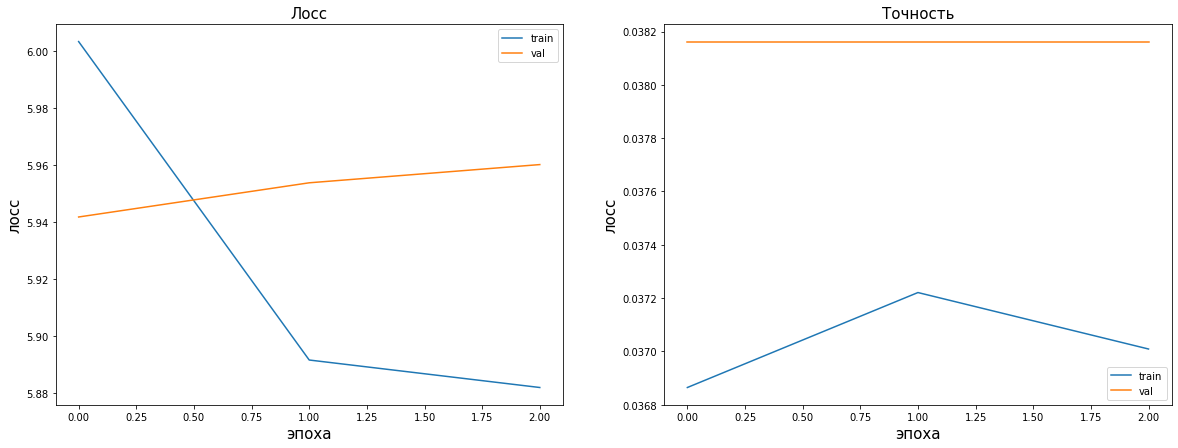

In [ ]:
model, history = train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen,
    "first_exp", num_epochs=50)

In [ ]:
source = torch.rand((1, 10, 25))
# now we expand to size (7, 11) by appending a row of 0s at pos 0 and pos 6, 
# and a column of 0s at pos 10
result = F.pad(input=source, pad=(0, 0, 0, 10), mode='constant', value=0)
source.shape, result.shape


(torch.Size([1, 10, 25]), torch.Size([1, 20, 25]))

In [ ]:
x = torch.rand(2, 3)
torch.cat([x, x, x])

tensor([[0.4858, 0.0038, 0.1553],
        [0.5837, 0.1532, 0.2017],
        [0.4858, 0.0038, 0.1553],
        [0.5837, 0.1532, 0.2017],
        [0.4858, 0.0038, 0.1553],
        [0.5837, 0.1532, 0.2017]])

**Conclusion:** whatever the results are, we do not have appropriate resources at the moment to train nerual networks on GBs of data. 